In [192]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from plot_params import * 
from scipy.stats import anderson, expon

In [2]:
def task(env, server, processing_time, waiting_time):
    """task arrives, is served and leaves."""
    arrive = env.now
    with server.request() as req:
        yield req
        waiting_time.append(env.now-arrive)
        #print('Task %s arrived at: %7.4f: ' % (arrive))
        yield env.timeout(processing_time)
        #print('Task %s finished at %s' % (env.now))

In [173]:
class Setup_mse(object):
    def __init__(self, env, arrival_rate, processing_capacity, server, waiting_times, desired_mse):
        self.env = env
        self.arrival_rate = arrival_rate
        self.processing_capacity = processing_capacity
        self.server = server
        self.waiting_times = waiting_times
        self.converged = env.event()
        self.desired_mse = desired_mse
        self.action = env.process(self.run())
    
    def run(self):
        while True:
            if  len(self.waiting_times)>50:
                waiting_time_mean = np.mean(self.waiting_times)
                #mse = (np.square(self.waiting_times - waiting_time_mean)).mean(axis=0)
                mse = mean_squared_error(self.waiting_times, [waiting_time_mean]*len(self.waiting_times))/len(self.waiting_times)
                #print(mse)
                #se = 1/(len(self.waiting_times)*waiting_rate**2)
                if mse < self.desired_mse:
                    self.converged.succeed()
                    self.converged = self.env.event()
                    
            arrival_time = random.expovariate(self.arrival_rate)
            yield env.timeout(arrival_time)

            processing_time = random.expovariate(self.processing_capacity)
            env.process(task(self.env, self.server, processing_time, waiting_times))
            
class Setup_samples(object):
    def __init__(self, env, arrival_rate, processing_capacity, server, waiting_times, n_samples):
        self.env = env
        self.arrival_rate = arrival_rate
        self.processing_capacity = processing_capacity
        self.server = server
        self.waiting_times = waiting_times
        self.n_samples_reached = env.event()
        self.n_samples = n_samples
        self.action = env.process(self.run())
    
    def run(self):
        while True:
            if  len(self.waiting_times)>self.n_samples:
                self.n_samples_reached.succeed()
                self.n_samples_reached = self.env.event()
            
            arrival_time = random.expovariate(self.arrival_rate)
            yield env.timeout(arrival_time)
            processing_time = random.expovariate(self.processing_capacity)
            env.process(task(self.env, self.server, processing_time, waiting_times))

66.84653339003606 0.4559652067617556
999998.9999712444


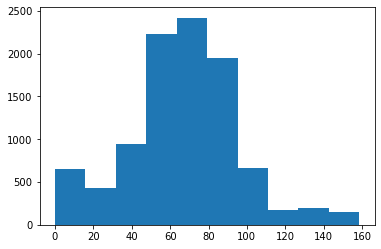

In [16]:
plt.hist(waitingtimes)
mean = np.mean(waitingtimes)
var = 1/(len(waitingtimes)*mean**-2)
print(mean, var)
print((server_util/capacity)/(1-server_util))

In [231]:
n_steps = 20
n_servers = 1
arrival_rate = 1
init_util = 0.5
final_util = 0.9
server_util = np.linspace(init_util, final_util, n_steps)
processing_capacity = 1/server_util
desired_mse = 0.5
n_samples = 10000
n_samples_var = np.zeros(n_steps)
mean_waiting = np.zeros(n_steps)
mse_waiting = np.zeros(n_steps)
for i in tqdm(range(n_steps), desc='calculate number of samples'):
    env = simpy.Environment()
    servers = simpy.Resource(env, capacity=n_servers)
    waiting_times = []
    setup = Setup_mse(env, arrival_rate, processing_capacity[i], servers, waiting_times, desired_mse)
    env.run(until=setup.converged)
    n_samples_var[i] = len(setup.waiting_times)

    env = simpy.Environment()
    servers1 = simpy.Resource(env, capacity=n_servers)
    waiting_times = []
    setup1 = Setup_samples(env, arrival_rate, processing_capacity[i], servers1, waiting_times, n_samples)
    env.run(until=setup1.n_samples_reached)
    mean_waiting[i] = np.mean(setup1.waiting_times[100:])
    #mse_waiting[i] = (np.square(setup1.waiting_times - mean_waiting[i])).mean(axis=0)
    n = len(setup1.waiting_times[100:])
    mse_waiting[i] = mean_squared_error(setup1.waiting_times[100:], [mean_waiting[i]]*n)/n


calculate number of samples: 100%|█████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.12it/s]


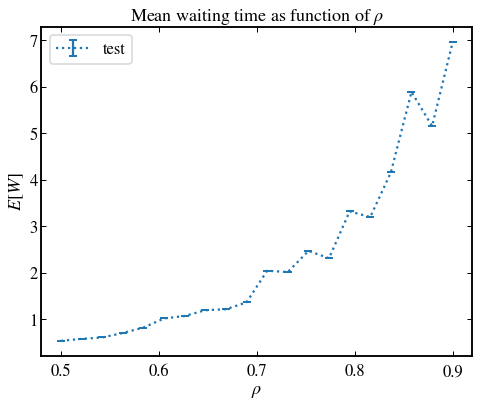

In [232]:
plt.errorbar(
    server_util, 
    mean_waiting, mse_waiting, 
    fmt=':', 
    capsize=4, 
    capthick=2, 
    label='test'
)
plt.fill_between(server_util, mean_waiting - mse_waiting, mean_waiting + mse_waiting, alpha=0.2)
plt.legend()
plt.title(r'Mean waiting time as function of $\rho$')
plt.xlabel(r'$\rho$')
plt.ylabel('$E[W]$')
plt.tight_layout()
#plt.savefig('figures/area_conv_s.pdf')
plt.show()

(array([33.,  7., 11., 10., 10.,  6.,  6., 15.,  1.,  2.]),
 array([ 0.        ,  1.05995827,  2.11991653,  3.1798748 ,  4.23983307,
         5.29979133,  6.3597496 ,  7.41970786,  8.47966613,  9.5396244 ,
        10.59958266]),
 <BarContainer object of 10 artists>)

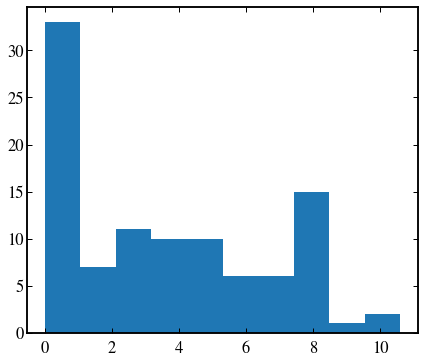

In [168]:
plt.hist(setup1.waiting_times)